# Project 2 : Classification of Hsp70 proteins into taxonomic groups based on their amino acid sequences
 This notebook shows how we prepare the dataset, train the model and analyze the features importance. This notebook does not contain the code to compute the variation of the results (performances and feature importance), as this simply repeats what this notebook does but 30 times to obtain a statistical representation of the computed quantities. The code to be able to compute the mean and standard deviation (given in the report), is still provided in an additional notebook called `Notebook_MTP_project2_results.ipynb` . Some cells may take a lot of time to run (especially the hyperparameters optimizations) so please be aware of the estimated time indications. These time indications have been estimated using the CPU of a standard laptop.

## Table of contents
1. [Import libraries](#1.-Import-libraries)
2. [Importing and treating the dataset](#2.-Importing-and-treating-the-data-set)
3. [T-distributed stochatic neighbor embedding](#3.-TSNE)
4. [Mutual information](#4.-Mutual-information)
5. [Training of the random forest](#5.-Random-Forest)
6. [Training of the Neural Network](#6.-Neural-Network)
7. [Features importance](#7.-Features-importance)

## 1. Import libraries and install requirements
The first cell download all the required libraries. See README.md for more informations

In [2]:
%pip install -q --upgrade --user -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.1.2 requires torch==2.1.2, but you have torch 2.2.1 which is incompatible.
torchvision 0.16.2 requires torch==2.1.2, but you have torch 2.2.1 which is incompatible.


In [11]:
level3

,Hsp70_sequence,level 3
0,AIGIDLGTTYSCVGVWQHDRVEIIANDQGNRTTPSYVAFTDSERLI...,Others
1,IIGIDLGTTNSLVSYFTEGGPVIIPNRLGDNLTPSVVSINEEEIYV...,Others
2,VVGIDLGNLNTCIAVARRGGIDVIVNETSNRATPSLVSFGQKNRYL...,Opisthokonta
3,IIGIDLGTTNSCVSVLEDGKPRVIENSEGDRTTPSIVAFTKDEVLV...,Pseudomonadota
4,IIGIDLGTTNSCVAVMEGGKPVVVTNTEGSRTTPSVVAFTKTERLV...,Others
...,...,...
98501,IIGIDLGTTNSVVAVMEGKEPKVIANKEGNRLTPSVVAFNDKETLV...,Others
98502,IVGIDLGTTNSLVAYIQTREATAIKDAQGNKLVPSVVHFTPGGILV...,Others
98503,IIGIDLGTTNSCVSVMEGNEPVVIQNSEGKRTTPSVVAFVEGERKV...,Others
98504,IIGIDLGTTNSCVSVMEGGEPKVIANEEGGRTTPSIVAFTKSERLV...,Others


In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np

%load_ext autoreload
%autoreload 2

import pandas as pd

from create_batch import *
from datatreatment import *
from neuralnet import *
from visualisations import *
from mutual_info import *
from TSNE import *
from train_rdf import *
from rdf_hyperpara_opti import *
from nn_hyperpara_opti import *

C:\Users\pierr\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 2. Importing and treating the dataset
This section performs the feature embedding and selects the level of taxonomy where the model will be trained. Make sure to change the path_to_dataset variable. This section can be run in more or less 10 seconds.

In [2]:
#path_to_dataset ="C:\\Users\\pierr\\OneDrive\\Bureau\\Semester_project_MA2\\dataset_hsp70_tax.csv" 
path_to_dataset ="C:\\Users\\pierr\\Desktop\\Semester_project_Ma2\\dataset_hsp70_tax\\dataset_hsp70_tax.csv"
hsp70 = importing_data(path_to_dataset)

In [3]:
level3, level3_categ= get_data(hsp70, 3, 3,Use_Others=True)
level3=encode01(level3)
level3=category_to_int(level3,level3_categ)

number of Opisthokonta : 
{25989}
---------
number of Pseudomonadota : 
{23889}
---------
number of Others : 
{48628}
---------


MemoryError: Unable to allocate 2.07 MiB for an array with shape (22, 98506) and data type bool

## 3. TSNE
This section performs the T-distributed stochatic neighbor embedding analysis. If done on the entire dataset, it takes 30 minutes. It can also be done on a smaller set by changing the argument of the split_dataset() function.
`X_tsne,labels_tsne,_,_,_,_=split_dataset(level3, 0.1, 0, 0)` will only execute the analysis on 10% of the dataset. Note that TSNE contains randomness, so results may vary slightly from the report and if you change the size of the subset you may need to adapt the complexity (typically a complexitiy of 150 works great with 50% of the dataset).

In [ ]:
perplexity = 350
X_tsne, labels_tsne, _, _, _, _=split_dataset(level3, 1, 0, 0)
tsne = compute_tsne(X_tsne, perplexity)
plot_tsne(tsne, labels_tsne,level3_categ)

## 4. Mutual information
This section computes the mutual information of the features in the dataset. The computation takes approximately 2 hours but can be done on a subset of the entire dataset. `mutual_data = compute_mutual_info(level3,0.1)` will perform the computation on 10 % of the dataset. We also provide a txt file `mutual_data.txt`that contains the calculated values. So, if you want to proceed without waiting for the computation (`mutual_data` is used further), just run the second cell.

In [189]:
mutual_data = compute_mutual_info(level3,0.5)
np.savetxt('mutual_data.txt', mutual_data)

Mutual info computed in 2177.7462663650513 seconds


In [4]:
mutual_data = np.loadtxt('mutual_data.txt',dtype=float)

## 5. Random Forest
This section does the training and hyperparameters optimization of the Random Forest. The hyperparameters optimization for the grid done below takes 14 hours to run. The second cell contains the optimal parameters discribed in the report, so skip the first cell if you don't want to go through the hyperparameter optimizations. The training of the Random Forest, with the hyperparameters that we selected, takes 4 minutes.

In [12]:
parameter_grid = {
        'n_estimators': [50,100],
        'max_depth':[200,300,400],
        'max_features':[100,200,400],
        'bootstrap':[False,True],
        'class_weight':['balanced'], 
        'min_samples_leaf':[5,10,20]
        }
train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.8, 0.1, 0.1)


best_para = optimize_hyperparameters_rf(train, train_label, test, test_label,parameter_grid,15)

Hyperparameters: {'n_estimators': 50, 'max_depth': 200, 'max_features': 100, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 5}, Mean Validation F1 Score: 0.9782196107633048, Std Validation F1 Score: 0.0012449193025149876
Hyperparameters: {'n_estimators': 50, 'max_depth': 200, 'max_features': 100, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 10}, Mean Validation F1 Score: 0.9709223045157904, Std Validation F1 Score: 0.0020324719654560685
Hyperparameters: {'n_estimators': 50, 'max_depth': 200, 'max_features': 100, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 20}, Mean Validation F1 Score: 0.9632317661386275, Std Validation F1 Score: 0.0023266103153564703
Hyperparameters: {'n_estimators': 50, 'max_depth': 200, 'max_features': 100, 'bootstrap': True, 'class_weight': 'balanced', 'min_samples_leaf': 5}, Mean Validation F1 Score: 0.9743166271401766, Std Validation F1 Score: 0.0013009460542162095
Hyperparameters: {'n_estimators

In [44]:
best_para = ({'n_estimators': 100, 'max_depth': 400, 'max_features': 400, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 5}, 0, 0)

In [13]:
model_rdf = train_random_forest(train, train_label,test, test_label,best_para[0])
val_pred = model_rdf.predict(val)
#convolution_matrix(val_label,val_pred,level3_categ)

Parameters are: {'n_estimators': 100, 'max_depth': 400, 'max_features': 400, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 5}
Training done


## 6. Neural Network
This section does the training and hyperparameters optimization of the Neural Network. The hyperparameters optimization for the grid done below takes 14 hours to run using a GPU. The second cell contains the optimal parameters discribed in the report, so skip the first cell if you don't want to go through the hyperparameter optimization. Also, don't execute the second one if you want to use your optimized hyperparameters. The training of the Neural Network, with the hyperparameters that we selected, takes 20 seconds if a GPU is used and 4 minutes the computation is done on the CPU.

In [9]:
param_grid = {
        'layer_dim': [128,256],
        'number_hidden_layer': [2,3,4],
        'dropout_prob': [0.2,0.25,0.3],
        'l2_regu': [1e-05],
        'weight_decay': [0.0001],
        'learning_rate':[0.001, 0.0001],
        'batch_size':[256, 128],
        'num_epochs':[10 ,15]
        }
train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.8, 0.1, 0.1)
cv=5
best_params_nn, mean_f1_score_nn, std_f1_score_nn = optimize_hyperparameters_nn(train, train_label, val, val_label, cv,param_grid)

time: 83.77799010276794

Hyperparameters: {'layer_dim': 128, 'number_hidden_layer': 2, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.001, 'batch_size': 256, 'num_epochs': 10}, Mean Validation F1 Score: 0.989342461502481, Std Validation F1 Score: 0.0006910267700073598

time: 206.0108118057251

Hyperparameters: {'layer_dim': 128, 'number_hidden_layer': 2, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.001, 'batch_size': 256, 'num_epochs': 15}, Mean Validation F1 Score: 0.9890170109689297, Std Validation F1 Score: 0.0009072761924932362

time: 358.2403042316437

Hyperparameters: {'layer_dim': 128, 'number_hidden_layer': 2, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 10}, Mean Validation F1 Score: 0.9887340241816054, Std Validation F1 Score: 0.0006797759451958068

time: 565.7202155590057

Hyperparameters: {'layer_dim': 128, 'number_hidden_layer':

In [22]:
best_params_nn = {'layer_dim': 128, 'number_hidden_layer': 3, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.0001, 'batch_size': 256, 'num_epochs': 10}

In [23]:
layer_dim = best_params_nn['layer_dim']
number_hidden_layer = best_params_nn['number_hidden_layer']
dropout_prob = best_params_nn['dropout_prob']
l2_regu = best_params_nn['l2_regu']
weight_decay = best_params_nn['weight_decay']
learning_rate = best_params_nn['learning_rate']
batch_size = best_params_nn['batch_size']
num_epochs = best_params_nn['num_epochs']

#train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.8, 0.1, 0.1)
train = torch.cat([train,val],dim = 0)
train_label = torch.cat([train_label,val_label],dim = 0)
input_dim = train.shape[1]
output_dim = 3

Epoch [1/15], Training Loss: 0.0395
Epoch [1/15], Validation Loss: 0.0405
Epoch [1/15], Validation Accuracy: 99.0863%
Epoch [2/15], Training Loss: 0.0366
Epoch [2/15], Validation Loss: 0.0341
Epoch [2/15], Validation Accuracy: 99.2690%
Epoch [3/15], Training Loss: 0.0160
Epoch [3/15], Validation Loss: 0.0331
Epoch [3/15], Validation Accuracy: 99.3299%
Epoch [4/15], Training Loss: 0.0074
Epoch [4/15], Validation Loss: 0.0305
Epoch [4/15], Validation Accuracy: 99.3401%
Epoch [5/15], Training Loss: 0.0286
Epoch [5/15], Validation Loss: 0.0289
Epoch [5/15], Validation Accuracy: 99.4112%
Epoch [6/15], Training Loss: 0.0049
Epoch [6/15], Validation Loss: 0.0315
Epoch [6/15], Validation Accuracy: 99.3503%
Epoch [7/15], Training Loss: 0.0102
Epoch [7/15], Validation Loss: 0.0293
Epoch [7/15], Validation Accuracy: 99.4112%
Epoch [8/15], Training Loss: 0.0207
Epoch [8/15], Validation Loss: 0.0286
Epoch [8/15], Validation Accuracy: 99.3909%
Epoch [9/15], Training Loss: 0.0351
Epoch [9/15], Valida

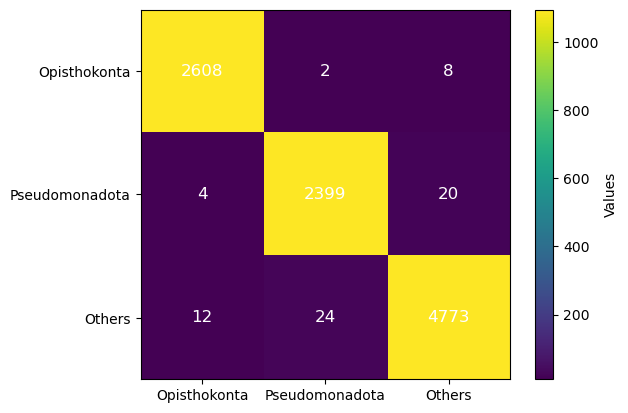

In [21]:
model_neural = ModelClassification(input_dim, output_dim, layer_dim, number_hidden_layer, dropout_prob, l2_regu)
optimizer = torch.optim.Adam(model_neural.parameters(), lr = learning_rate, weight_decay=weight_decay)
train_model(model_neural, num_epochs, train, train_label, test, test_label, optimizer, batch_size)


if torch.cuda.is_available():
    model_neural = model_neural.cpu()
test_outputs = model_neural(test)
test_pred = test_outputs.argmax(dim=1)
convolution_matrix(test_label,test_pred,level3_categ)

## 7. Features importance
This section computes the features importance in both model and standardizes them. They are then plotted in comparison with the mutual informations to be able to see which region of the sequence is more important for the task. Note that the signal is filtered through a moving average of size `smoothness`. The first cell contains the feature importance calculated by all models and the second is just the feature importance in the neural network However, the importance is divided between each class to observe whether they match. We provide 2 .pkl files to be able to visualize the importances without the need to run the entire notebook. If you want to compute the features importance of the models trained, do not run the first cell.

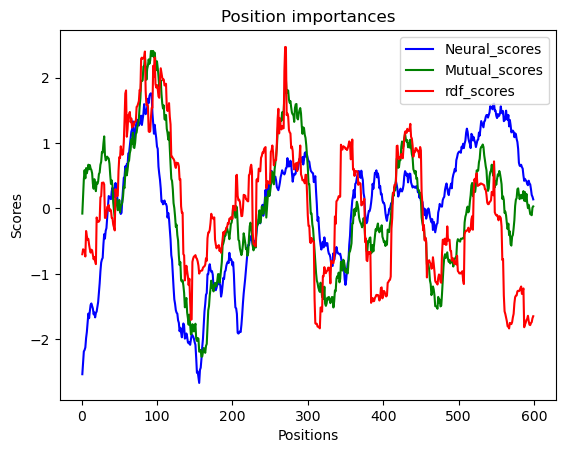

,Neural_scores,Mutual_scores,rdf_scores
pos_1,-2.533769,-0.078553,-0.700124
pos_2,-2.356133,0.170540,-0.624415
pos_3,-2.185374,0.444653,-0.633374
pos_4,-2.163838,0.584786,-0.647598
pos_5,-2.125219,0.460571,-0.734230
...,...,...,...
pos_595,0.367710,-0.086501,-1.783398
pos_596,0.294364,-0.093925,-1.752087
pos_597,0.205850,-0.103447,-1.736835
pos_598,0.179223,0.013495,-1.678276


In [15]:
feature_importances(model_rdf, model_neural, mutual_data, level3, smoothness = 40, plot = 1)

In [ ]:
features_impo = pd.read_pickle('features_impo.pkl')
features_impo_nn = pd.read_pickle('features_impo_nn.pkl')

In [ ]:
features_impo = feature_importances(model_rdf, model_neural, mutual_data, level3, smoothness = 30)
features_impo.to_pickle("features_impo.pkl")

In [ ]:
features_impo_nn = features_importances_nn(model_neural, level3, smoothness = 30, plot=1)
features_impo_nn.to_pickle("features_impo_nn.pkl")

## Plot finaux

In [10]:
best_params_nn = {'layer_dim': 128, 'number_hidden_layer': 3, 'dropout_prob': 0.2, 'l2_regu': 1e-05, 'weight_decay': 0.0001, 'learning_rate': 0.0001, 'batch_size': 256, 'num_epochs': 10}
layer_dim = best_params_nn['layer_dim']
number_hidden_layer = best_params_nn['number_hidden_layer']
dropout_prob = best_params_nn['dropout_prob']
l2_regu = best_params_nn['l2_regu']
weight_decay = best_params_nn['weight_decay']
learning_rate = best_params_nn['learning_rate']
batch_size = best_params_nn['batch_size']
num_epochs = best_params_nn['num_epochs']


best_para = ({'n_estimators': 100, 'max_depth': 400, 'max_features': 400, 'bootstrap': False, 'class_weight': 'balanced', 'min_samples_leaf': 5}, 0, 0)

dfs = []
for i in range(30):
    
    
    train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.9, 0.1, 0)
    
    model_rdf = train_random_forest(train, train_label,test, test_label,best_para[0])
    model_neural = ModelClassification(input_dim, output_dim, layer_dim, number_hidden_layer, dropout_prob, l2_regu)
    optimizer = torch.optim.Adam(model_neural.parameters(), lr = learning_rate, weight_decay=weight_decay)#lr : learning rate
    train_model(model_neural, num_epochs, train, train_label, test, test_label, optimizer, batch_size)
    
    dfs.append(feature_importances(model_rdf, model_neural, mutual_data, level3, smoothness = 40, plot = 0))

    mutual_data = compute_mutual_info(level3,1)
    
    
    

arrays = [df.to_numpy() for df in dfs]

stacked_array = np.stack(arrays, axis=0)
mean_values = np.mean(stacked_array, axis=0)
std_values = np.std(stacked_array, axis=0)


np.savetxt('mean.txt', mean_values)
np.savetxt('std.txt', std_values)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\pierr\anaconda3\envs\Cuda\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\pierr\AppData\Local\Temp\ipykernel_66192\1665171161.py", line 18, in <module>
    train, train_label, test, test_label, val, val_label=split_dataset(level3, 0.9, 0.1, 0)
                                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\pierr\Desktop\Semester_project_Ma2\create_batch.py", line 63, in split_dataset
    train_set = torch.tensor(trainset.iloc[:, 1:].values, dtype=torch.float32)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

During handling of the above exception, another exception occurred:

Traceb

In [30]:
mean_values = np.loadtxt('mean.txt',dtype=float)
std_values = np.loadtxt('std.txt',dtype=float)



plt.plot(np.arange(mean_values.shape[0]), mean_values[:, 0],label='Neural Network', color="red", lw=2) 

plt.fill_between(
    np.arange(mean_values.shape[0]),
    mean_values[:, 0] - std_values[:, 0],
    mean_values[:, 0] + std_values[:, 0],
    color="red",
    alpha=0.3 
)
plt.plot(np.arange(mean_values.shape[0]), mean_values[:, 1], label='Mutual Information', color="green", lw=2) 
plt.fill_between(
    np.arange(mean_values.shape[0]),
    mean_values[:, 1] - std_values[:, 1],
    mean_values[:, 1] + std_values[:, 1],
    color="green",
    alpha=0.3 
)
plt.plot(np.arange(mean_values.shape[0]), mean_values[:, 2], label='Random forest', color="blue", lw=2) 
plt.fill_between(
    np.arange(mean_values.shape[0]),
    mean_values[:, 2] - std_values[:, 2],
    mean_values[:, 2] + std_values[:, 2],
    color="blue",
    alpha=0.3 
)


plt.xlabel('Positions')
plt.ylabel('Scores')
plt.title('Position importances')
plt.legend()

plt.show()


FileNotFoundError: mean.txt not found.